# Calculate POI Proximities

#### Primary Author
Chris Carey

#### Description:
This notebook produces proximity indices for census block groups (CBGs) which estimate the level of food access to various food retail or service point of interests (POIs) by accumulating the exponentially-weighted inverse great-circle distance from a CBG to a POI.

#### Limitations:
- Great-circle distance rather than travel time is used
- By default, distance to the centroid of the POI's CBG for efficiency as these distances are precomputed
[//]: # (EOL)
 
#### Inputs:
```
data/nyc_cbgs.geojson
data/nyc_cbg_centroids.geojson
data/nyc_cbg_attr_and_cluster_1021.csv
exports/poi_health_recategorized.csv
exports/cbg_distance_matrix_sorted.csv
```
 
#### Outputs:
```
exports/proximity_indices.csv
```
#### Visualizations:
> Choropleth of POI proximity index by census block group (CBG)

In [1]:
import geopandas as gpd
from shapely.geometry import Point
import geopy.distance
import math
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from tqdm import tqdm

import warnings
warnings.filterwarnings('ignore')

In [2]:
CRS = 'EPSG:4326'

In [3]:
cbg_polygon_gdf = gpd.read_file('./data/nyc_cbgs.geojson')
cbg_polygon_gdf = cbg_polygon_gdf.to_crs(CRS)
cbg_polygon_gdf = cbg_polygon_gdf.rename(columns={
    'CensusBlockGroup': 'cbg',
})
cbg_polygon_gdf['cbg'] = cbg_polygon_gdf['cbg'].astype(int)
cbg_polygon_gdf = cbg_polygon_gdf[['cbg', 'geometry']]

cbg_point_gdf = gpd.read_file('./data/nyc_cbg_centroids.geojson')
cbg_point_gdf = cbg_point_gdf.to_crs(CRS)
cbg_point_gdf = cbg_point_gdf.rename(columns={
    'CensusBlockGroup': 'cbg',
})
cbg_point_gdf['cbg'] = cbg_point_gdf['cbg'].astype(int)
cbg_point_gdf = cbg_point_gdf[['cbg', 'geometry']]

cbg_df = pd.read_csv('./data/cbg_attr_and_cluster_1021.csv')
cbg_df = cbg_df.rename(columns={
    'census_block_group': 'cbg',
    'Cluster': 'cluster',
    'Total Population': 'population',
})
cbg_df = cbg_df[['cbg', 'cluster', 'population']]
cbg_df['cluster'] = cbg_df['cluster'].astype('category')

cbg_polygon_gdf = cbg_polygon_gdf.merge(cbg_df, how='inner', on=['cbg'])
cbg_point_gdf = cbg_point_gdf.merge(cbg_df, how='inner', on=['cbg'])

In [4]:
def plot(polygon_gdf, point_gdf, SIZE=10):
    fig, ax = plt.subplots(figsize=(SIZE, SIZE))
    polygon_gdf.plot(ax=ax, color='#eee')
    point_gdf.plot(ax=ax, color='C0', markersize=1)
    plt.tight_layout()
    plt.show()

In [5]:
poi_df = pd.read_csv('./exports/poi_health_recategorized.csv')
poi_gdf = gpd.GeoDataFrame(poi_df,
                           geometry=gpd.points_from_xy(poi_df['longitude'],
                                                       poi_df['latitude']),
                           crs='EPSG:4326')
poi_gdf = poi_gdf.to_crs(CRS)
poi_gdf = poi_gdf.fillna(0)

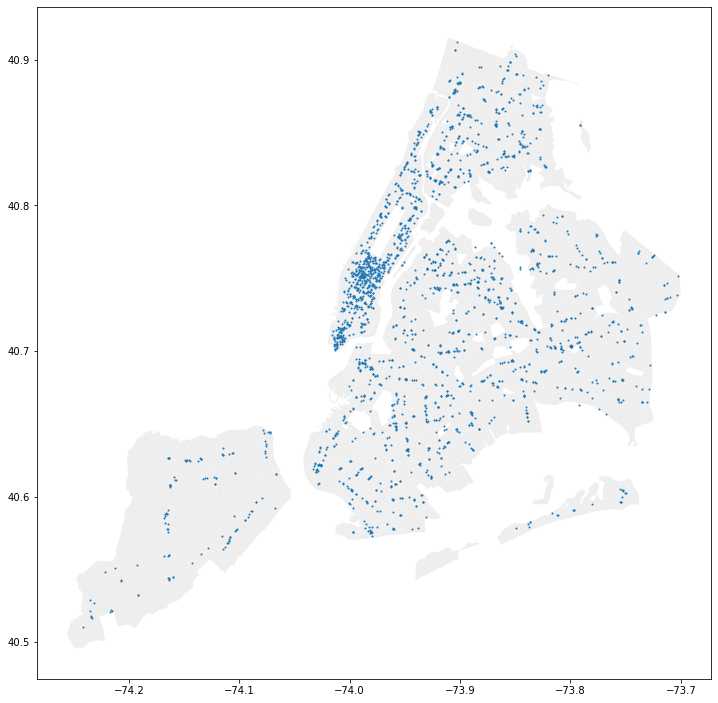

In [6]:
plot(cbg_polygon_gdf, poi_gdf[poi_gdf['category'] == 'Fast-Food Restaurants'])

In [7]:
# Precomputed CBG-CBG distances.
distance_df = pd.read_csv('./exports/cbg_distance_matrix_sorted.csv')
distance_df.head()
distance_df.index = distance_df['CensusBlockGroup']
distance_df = distance_df.drop(columns=['CensusBlockGroup'])
distance_df.columns = [int(col) for col in distance_df.columns]
distance_df.head()

,360050001000,360050001001,360050002000,360050002001,360050002002,360050002003,360050004000,360050004001,360050004002,360050004003,...,360850303024,360850319011,360850319012,360850319020,360850319021,360850319022,360850319023,360850323000,360850323001,360859901000
CensusBlockGroup,,,,,,,,,,,,,,,,,,,,,
360050001000,0.000000,510.184107,2253.930859,2908.658560,2747.635431,2790.143658,3262.243966,3125.707817,3311.478148,3068.237615,...,29724.718013,29673.815369,29903.932994,29143.538045,29615.529509,29508.871565,29325.023174,30362.586725,30588.175137,35420.378916
360050001001,510.184107,0.000000,2314.619204,3135.117417,2943.873653,2899.811979,3279.333935,3319.634020,3455.836254,3122.803193,...,29583.862410,29553.688246,29779.142536,29042.016267,29511.978716,29401.436203,29211.935518,30275.957548,30483.766418,35135.750522
360050002000,2253.930859,2314.619204,0.000000,1158.245457,899.130633,615.689556,1018.123605,1193.134662,1197.930632,815.589533,...,31896.603970,31868.307350,32093.670991,31355.096886,31825.380364,31715.334653,31526.325962,32585.710653,32797.305163,37313.796252
360050002001,2908.658560,3135.117417,1158.245457,0.000000,260.007453,733.055119,1353.427513,296.968734,660.888231,1075.579785,...,32621.490298,32557.760413,32791.119680,32012.320500,32486.030390,32382.800712,32203.667141,33216.256149,33459.215248,38267.042140
360050002002,2747.635431,2943.873653,899.130633,260.007453,0.000000,506.107000,1176.188904,378.355819,634.897451,886.800316,...,32471.715511,32416.229404,32647.746932,31878.225193,32351.178645,32246.360634,32064.922103,33088.431466,33324.144930,38063.336055


In [8]:
categories = list(set(poi_gdf['category']))
categories.sort()
display(categories)

['Community and Special Food Services',
 'Fast-Food Restaurants',
 'Food (Health) Supplement Stores',
 'General Merchandise and Convenience Stores',
 'Restaurants and Other Eating Places',
 'Supermarkets and Specialty Food Stores',
 'Tobacco and Liquor Stores']

In [23]:
# Lat/lon short-circuit distance for 1km.
THRESHOLD_1000 = 0.0001

def get_exact_area_proximity(p1, p2, r=1000, poi_area=1):
    # Short circuit using lat/lon squared distance before executing
    if (p1.x - p2.x)**2 + (p1.y - p2.y)**2 > THRESHOLD_1000:
        return 0
    gp1 = geopy.Point(latitude=p1.y, longitude=p1.x)
    gp2 = geopy.Point(latitude=p2.y, longitude=p2.x)
    
    # Use great-circle distance for speed.
    d = geopy.distance.great_circle(gp1, gp2).m
    
    # Return inverse-distance * POI area.
    return max(0, r - d) * poi_area

def get_area_proximity(cbg, poi_cbg, r, poi_area=1):
    # Use pre-computed CBG-CBG distance for speed.
    d = distance_df.loc[cbg, poi_cbg]
    
    # Return inverse-distance polynomial factot * POI area.
    return (1.003**max(0, r - d) - 1) * poi_area

In [24]:
INDEX_CBG = 1
INDEX_AREA = 6
SEARCH_RADIUS_IN_M = 5000


def get_proximity_index(poi_gdf, cbg_point):
    return np.sum([
        get_area_proximity(cbg_point, row[1][INDEX_CBG], SEARCH_RADIUS_IN_M)
        for row in poi_gdf.iterrows()
    ])


def get_area_proximity_index(poi_gdf, cbg_point):
    return np.sum([
        get_area_proximity(cbg_point,
                           row[1][INDEX_CBG],
                           SEARCH_RADIUS_IN_M,
                           poi_area=row[1][INDEX_AREA])
        for row in poi_gdf.iterrows()
    ])

In [25]:
tqdm.pandas()
sample_gdf = poi_gdf.sample(frac=0.5)
for i, category in enumerate(categories):
    poi_cat_gdf = sample_gdf[sample_gdf['category'] == category]
    cbg_polygon_gdf[f'category_{i}_proximity_index'] = (
        cbg_point_gdf['cbg'].progress_apply(
            lambda x: get_proximity_index(poi_cat_gdf, x)))

100%|██████████| 6221/6221 [14:41<00:00,  7.05it/s]


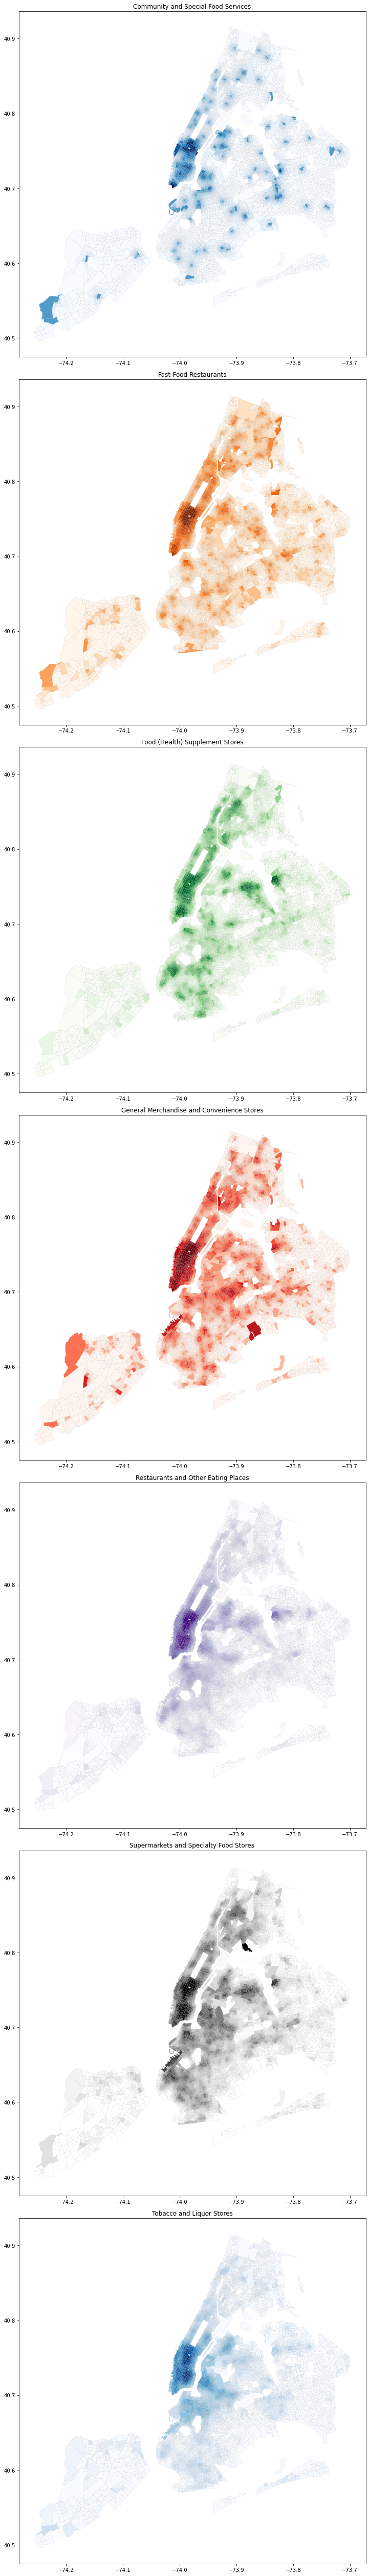

In [26]:
N_CAT = len(categories)
cmaps = ['Blues', 'Oranges', 'Greens', 'Reds', 'Purples', 'Greys']

fig, ax = plt.subplots(N_CAT, 1, figsize=(10, 10 * N_CAT))
for i, category in enumerate(categories):
    cbg_polygon_gdf.plot(ax=ax[i],
                         column=f'category_{i}_proximity_index',
                         scheme='FisherJenksSampled',
                         cmap=cmaps[i % len(cmaps)],
                         edgecolor='#999',
                         linewidth=0.1,
                         k=20)
    ax[i].set_title(category)
plt.tight_layout()
plt.show()

In [13]:
cbg_polygon_gdf[['cbg'] + [f'category_{i}_proximity_index' for i in range(0, N_CAT)]].to_csv('./exports/proximity_index.csv', index=False)